In [2]:
# Download the dataset
import os
from pathlib import Path
from datasets import load_dataset

dataset = load_dataset("chittaranjankhatua/car_damage_pub")

folder = 'car_damage'
path = Path(folder)
if not path.exists():
    os.mkdir(folder)

# Writes dataset to file
for i in range(len(dataset['train']["image"])):
    image = dataset['train']["image"][i]
    image_name = str('car_damage/')+str(i)+str('.jpg')
    # Check if file exists
    file = Path(image_name)
    if not file.exists():

        # File does not exist, write image
        image.save(image_name)

    else:

        # File already exists, skip writing
        print(f'{image_name} already exists, skipping...')

/Users/shy/Projects/galaxy/env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Generating train split: 100%|██████████| 128/128 [00:00<00:00, 2479.28 examples/s]


In [1]:
# Data visualization
import matplotlib.pyplot as plt
from PIL import Image

def display_multiple_images(file_names):
    num_images = len(file_names)
    fig, axes = plt.subplots(1, num_images)
    fig.set_figwidth(5 * num_images)
    for ax, file_name in zip(axes, file_names):
        ax.imshow(Image.open(file_name))
        ax.axis("off")
    plt.show()

def display_single_image(file_name):
    fig, ax = plt.subplots(1, 1)
    fig.set_figwidth(3)
    ax.imshow(Image.open(file_name))
    ax.axis("off")

In [2]:
import json
import base64
import boto3

# calls Amazon Bedrock to get a vector from either an image, text, or both
def get_multimodal_vector(input_image_base64=None, input_text=None):
    bedrock = boto3.client(service_name='bedrock-runtime')
    request_body = {}
    if input_text:
        request_body["inputText"] = input_text
    if input_image_base64:
        request_body["inputImage"] = input_image_base64
    request_body["embeddingConfig"] = {"outputEmbeddingLength": 1024}
    body = json.dumps(request_body)
    response = bedrock.invoke_model(
        body=body, 
        modelId="amazon.titan-embed-image-v1", 
        accept="application/json", 
        contentType="application/json"
    )
    response_body = json.loads(response.get('body').read())
    embedding = response_body.get("embedding")
    return embedding

# creates a vector from an image file path
def get_vector_from_file(file_path):
    with open(file_path, "rb") as image_file:
        input_image_base64 = base64.b64encode(image_file.read()).decode('utf8')    
    vector = get_multimodal_vector(input_image_base64 = input_image_base64)
    return vector

In [3]:
# embed query testing for an image
embeddings = get_vector_from_file('./car_damage/0.jpg')
print(len(embeddings)) # length of embedding dimensions = 1 x 384
print(embeddings[:5])  # only include the first 5 elements

1024
[-0.0023599043, 0.02213116, -0.05925731, -0.03360323, -0.004177821]


In [4]:
from PIL import Image
import os
import chromadb
client = chromadb.HttpClient()

from chromadb import Documents, EmbeddingFunction, Embeddings

class TitanEmbedFunction(EmbeddingFunction):
    def __call__(self, files: Documents) -> Embeddings:
        # embed the documents somehow
        return [get_vector_from_file(file) for file in files]

class TitanTextEmbedFunction(EmbeddingFunction):
    def __call__(self, files: Documents) -> Embeddings:
        # embed the documents somehow
        return [get_multimodal_vector(input_text=file) for file in files]

In [5]:
embed_text = TitanTextEmbedFunction()

In [18]:

collection = client.get_or_create_collection("test")

In [10]:
from concurrent.futures import ThreadPoolExecutor, as_completed
from pathlib import Path

image_folder = Path('vids/frames/')
image_files = [f for f in image_folder.iterdir() if f.is_file()]

def process_image(image_file):
    img_embedding = get_vector_from_file(image_file)
    video_name, secs = image_file.stem.split("_")
    collection.add(
        embeddings=img_embedding,
        metadatas={"timestamp": secs, "video": video_name},
        ids=image_file.name
    )
    return image_file.name

with ThreadPoolExecutor() as executor:
    futures = [executor.submit(process_image, image_file) for image_file in image_files]
    for future in as_completed(futures):
        print(f"Inserted: {future.result()}")

print("All images inserted into Chroma.")

Inserted: frame_13.jpg
Inserted: frame_11.jpg
Inserted: frame_28.jpg
Inserted: frame_14.jpg
Inserted: frame_29.jpg
Inserted: frame_15.jpg
Inserted: frame_5.jpg
Inserted: frame_7.jpg
Inserted: frame_10.jpg
Inserted: frame_12.jpg
Inserted: frame_6.jpg
Inserted: frame_4.jpg
Inserted: frame_32.jpg
Inserted: frame_27.jpg
Inserted: frame_26.jpg
Inserted: frame_16.jpg
Inserted: frame_17.jpg
Inserted: frame_18.jpg
Inserted: frame_1.jpg
Inserted: frame_30.jpg
Inserted: frame_33.jpg
Inserted: frame_2.jpg
Inserted: frame_24.jpg
Inserted: frame_3.jpg
Inserted: frame_31.jpg
Inserted: frame_34.jpg
Inserted: frame_19.jpg
Inserted: frame_25.jpg
Inserted: frame_35.jpg
Inserted: frame_9.jpg
Inserted: frame_21.jpg
Inserted: frame_20.jpg
Inserted: frame_8.jpg
Inserted: frame_23.jpg
Inserted: frame_22.jpg
All images inserted into Chroma.


In [21]:
import subprocess

def extract_frames(video_name):
    input_path = Path(f'vids/{video_name}.mp4')
    temp_frames_path = Path(f'vids/{video_name}_frames.mp4')
    output_frames_folder = Path(f'vids/frames/{video_name}')
    output_frames_folder.mkdir(parents=True, exist_ok=True)
    
    if not temp_frames_path.exists():
        print(f"Extracting frame video from `{input_path}`...")
        subprocess.run(['ffmpeg', '-i', str(input_path), '-filter:v', 'fps=1', str(temp_frames_path)], check=True)
    if not output_frames_folder.exists():
        print(f"Made frames folder for `{video_name}`")
        output_frames_folder.mkdir(parents=True, exist_ok=True)
    if len(list(output_frames_folder.iterdir())) == 0:
        print(f"Extracting frames from `{temp_frames_path}` to `{output_frames_folder}`")
        subprocess.run(['ffmpeg', '-i', str(temp_frames_path), str(output_frames_folder / 'frame_%d.jpg')], check=True)

def process_video(video_name):
    extract_frames(video_name)
    image_folder = Path(f'vids/frames/{video_name}')
    image_files = [f for f in image_folder.iterdir() if f.is_file()]

    with ThreadPoolExecutor() as executor:
        futures = [executor.submit(process_image, image_file) for image_file in image_files]
        for future in as_completed(futures):
            print(f"Inserted: {future.result()}")

    print(f"All images from `{video_name}` inserted into Chroma.")

process_video("arborist")

Extracting frames from `vids/arborist_frames.mp4` to `vids/frames/arborist`


ffmpeg version 6.1.1 Copyright (c) 2000-2023 the FFmpeg developers
  built with Apple clang version 15.0.0 (clang-1500.1.0.2.5)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/6.1.1_4 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags='-Wl,-ld_classic' --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libopen

Inserted: frame_598.jpg
Inserted: frame_201.jpg
Inserted: frame_215.jpg
Inserted: frame_1134.jpg
Inserted: frame_573.jpg
Inserted: frame_771.jpg
Inserted: frame_942.jpg
Inserted: frame_981.jpg
Inserted: frame_956.jpg
Inserted: frame_995.jpg
Inserted: frame_759.jpg
Inserted: frame_765.jpg
Inserted: frame_567.jpg
Inserted: frame_1108.jpg
Inserted: frame_1083.jpg
Inserted: frame_361.jpg
Inserted: frame_229.jpg
Inserted: frame_1097.jpg
Inserted: frame_1040.jpg
Inserted: frame_375.jpg
Inserted: frame_407.jpg
Inserted: frame_1120.jpg
Inserted: frame_59.jpg
Inserted: frame_413.jpg
Inserted: frame_1054.jpg
Inserted: frame_71.jpg
Inserted: frame_349.jpg
Inserted: frame_65.jpg
Inserted: frame_822.jpg
Inserted: frame_163.jpg
Inserted: frame_836.jpg
Inserted: frame_1068.jpg
Inserted: frame_188.jpg
Inserted: frame_605.jpg
Inserted: frame_177.jpg
Inserted: frame_611.jpg
Inserted: frame_639.jpg
Inserted: frame_638.jpg
Inserted: frame_176.jpg
Inserted: frame_610.jpg
Inserted: frame_348.jpg
Inserted: f

In [17]:
#client.delete_collection("test")

In [38]:
results = collection.query(
    query_embeddings=embed_text(["standing on safety rope"]),
    n_results=1000,
    #where={"style": "style2"}
)


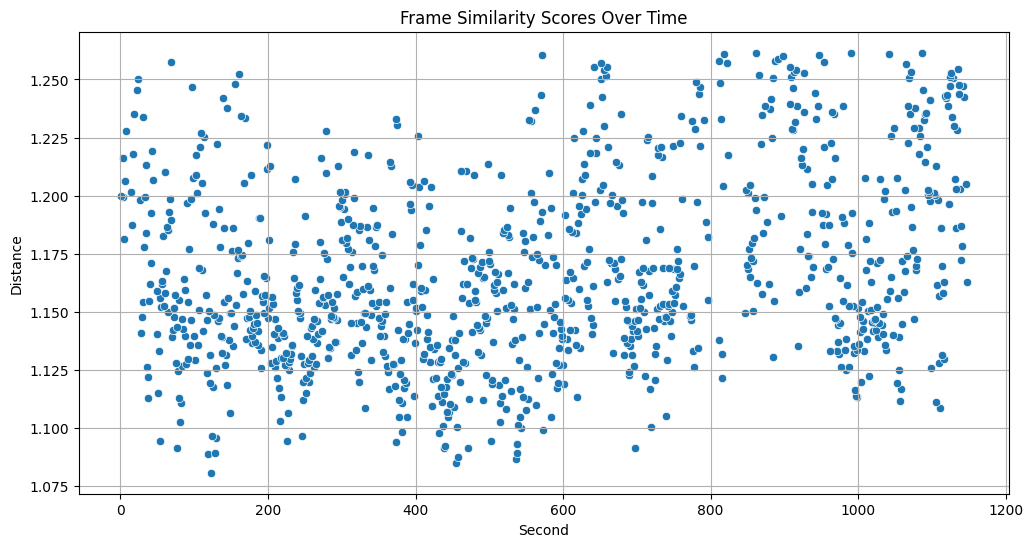

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def plot_similarity_scores(results):
    data = {
        'sec': [int(id.split('_')[1].split('.')[0]) for id in results['ids'][0]],
        'distance': results['distances'][0]
    }
    df = pd.DataFrame(data)
    
    plt.figure(figsize=(12, 6))
    sns.scatterplot(x='sec', y='distance', data=df, marker='o')
    plt.title('Frame Similarity Scores Over Time')
    plt.xlabel('Second')
    plt.ylabel('Distance')
    plt.grid(True)
    plt.show()

# Assuming `results` is the object containing 'ids' and 'distances'
plot_similarity_scores(results)

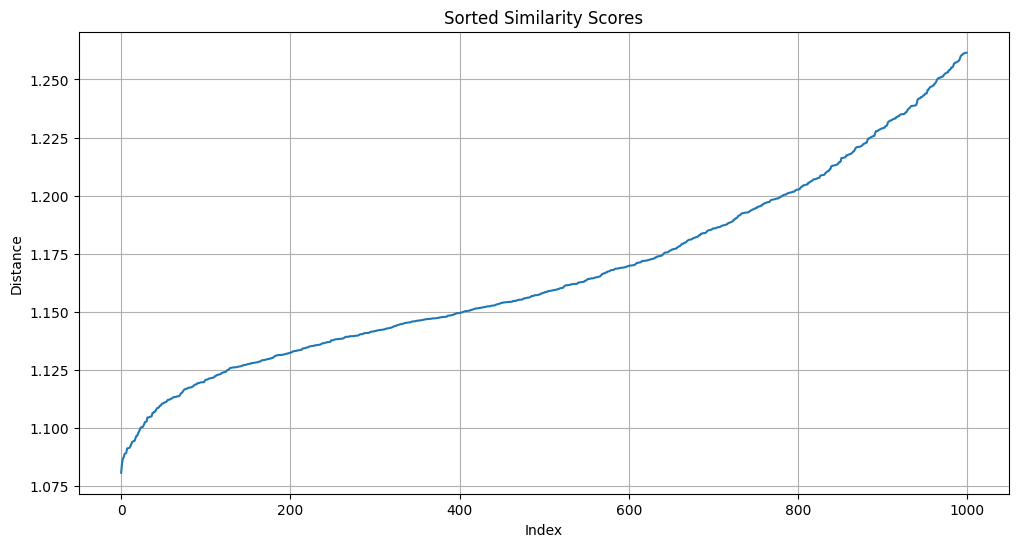

In [45]:
def plot_sorted_similarity_scores(results):
    distances = sorted(results['distances'][0])
    df = pd.DataFrame({'index': range(len(distances)), 'distance': distances})
    
    plt.figure(figsize=(12, 6))
    sns.lineplot(x='index', y='distance', data=df)
    plt.title('Sorted Similarity Scores')
    plt.xlabel('Index')
    plt.ylabel('Distance')
    plt.grid(True)
    plt.show()


# Assuming `results` is the object containing 'ids' and 'distances'

plot_sorted_similarity_scores(results)